In [1]:
import faiss
import torch

import os

import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np

from lib.model import ImMatchNet, MutualMatching
from lib.normalization import imreadth, resize, normalize, normalize_image
from lib.relocalize import relocalize, relocalize_soft, eval_model_reloc
from lib.sparse import get_matches_both_dirs

## Load pretrained model

In [2]:
checkpoint = '../trained_models/sparsencnet_k10.pth.tar'
chp_args = torch.load(checkpoint)['args']

In [3]:
model = ImMatchNet(use_cuda=True,
                   checkpoint=checkpoint,
                   ncons_kernel_sizes=chp_args.ncons_kernel_sizes,
                   ncons_channels=chp_args.ncons_channels,
                   sparse=True,
                   symmetric_mode=bool(chp_args.symmetric_mode),
                   feature_extraction_cnn=chp_args.feature_extraction_cnn,
                   bn=bool(chp_args.bn),
                   k=chp_args.k,
                   return_fs=True,
                   change_stride=1
                  )

Loading checkpoint...
Using checkpoint parameters: 
  ncons_channels: [16, 1]
  ncons_kernel_sizes: [3, 3]
Copying weights...
Done!
Changing FeatureExtraction stride


## Load images

In [4]:
image_size = 1600
scale_factor = 0.0625

src=imreadth('aachen_query.jpg')
hA,wA=src.shape[-2:]
src=resize(normalize(src), image_size, scale_factor)
hA_,wA_=src.shape[-2:]

tgt=imreadth('aachen_db.jpg')
hB,wB=tgt.shape[-2:]
tgt=resize(normalize(tgt), image_size, scale_factor)
hB_,wB_=tgt.shape[-2:]

## Run model

In [5]:
with torch.no_grad():
    corr4d, feature_A_2x, feature_B_2x, fs1, fs2, fs3, fs4 = eval_model_reloc(
        model,
        {'source_image':src,
         'target_image':tgt}
    )

#### Extract matches and run relocalization

In [6]:
Npts = 500

# extract matches
xA_, yA_, xB_, yB_, score_ = get_matches_both_dirs(corr4d, fs1, fs2, fs3, fs4)

# get top Npts
matches_idx_sorted = torch.argsort(-score_.view(-1))
N_matches = min(Npts, matches_idx_sorted.shape[0])
matches_idx_sorted = matches_idx_sorted[:N_matches]
score_ = score_[:,matches_idx_sorted]
xA_ = xA_[:,matches_idx_sorted]
yA_ = yA_[:,matches_idx_sorted]
xB_ = xB_[:,matches_idx_sorted]
yB_ = yB_[:,matches_idx_sorted]

# upscale feature sizes by 2x
fs1_,fs2_,fs3_,fs4_=2*fs1,2*fs2,2*fs3,2*fs4

# relocalization stage 1:
xA_, yA_, xB_, yB_, score_ = relocalize(xA_,
                                        yA_,
                                        xB_,
                                        yB_,
                                        score_,
                                        feature_A_2x,
                                        feature_B_2x,
                                        crop_size=2)

# relocalization stage 2:
xA_, yA_, xB_, yB_, score_ = relocalize_soft(xA_,yA_,xB_,yB_,score_,feature_A_2x, feature_B_2x, upsample_positions=False)

# normalize coords in [0,1] range
yA=((yA_+0.5)/(fs1_)).squeeze().cpu().numpy()
xA=((xA_+0.5)/(fs2_)).squeeze().cpu().numpy()
yB=((yB_+0.5)/(fs3_)).squeeze().cpu().numpy()
xB=((xB_+0.5)/(fs4_)).squeeze().cpu().numpy()

## Plot matches

In [7]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).cuda()
std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).cuda()

In [8]:
src_tgt = (torch.cat((src,tgt),dim=2)*std)+mean
src_tgt = src_tgt.squeeze().permute(1,2,0).mul(255).cpu().numpy().astype(np.uint8)

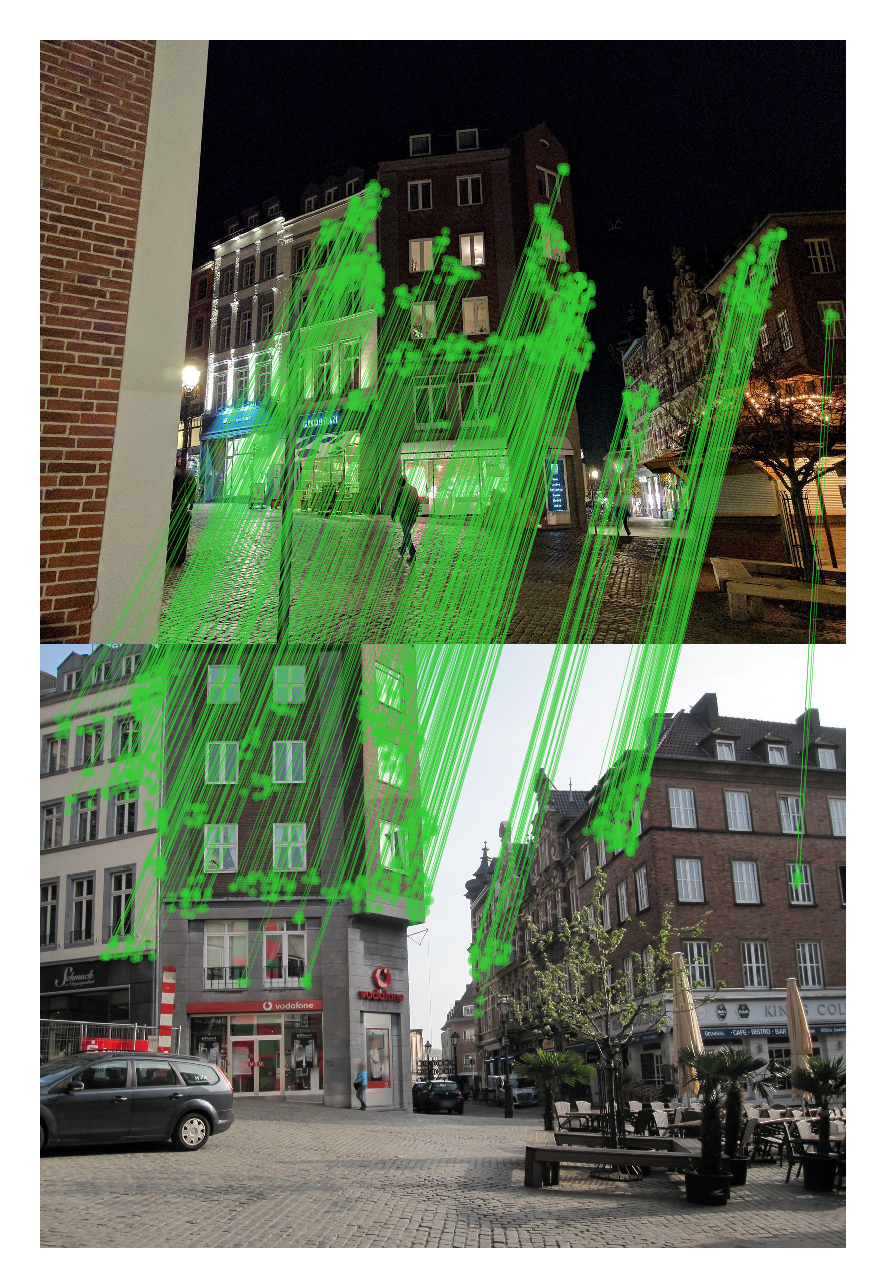

In [9]:
plt.imshow(src_tgt)
plt.axis('off')
plt.scatter(xA*wA_,yA*hA_,0.5,c='limegreen',alpha=0.5)
plt.scatter(xB*wB_,yB*hB_+hA_,0.5,c='limegreen',alpha=0.5)
plt.plot(np.stack((xA*wA_,xB*wB_)),
         np.stack((yA*hA_,yB*hB_+hA_)),
         c='limegreen',
         linewidth=0.1)
plt.gcf().set_dpi(400)